In [1]:
import requests
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import ParameterGrid
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Function to fetch historical weather data from WeatherAPI
def fetch_historical_weather_data(api_key, location, date):
    url = f"http://api.weatherapi.com/v1/history.json?key={api_key}&q={location}&dt={date}"
    response = requests.get(url)
    data = response.json()

    # Extracting necessary features
    features = []
    for day in data['forecast']['forecastday']:
        features.append({
            'date': day['date'],
            'max_temp': day['day']['maxtemp_c'],
            'min_temp': day['day']['mintemp_c'],
            'avg_temp': day['day']['avgtemp_c'],
            'humidity': day['day']['avghumidity'],
            'heat_index': day['day'].get('heatindex_c', None),  # Use .get to avoid KeyError
            'uv': day['day']['uv'],
        })

    return pd.DataFrame(features)

# Fetching a large amount of historical weather data
API_KEY = '65652209b11c49928c0132348243108'  # Replace with your actual API key
LOCATION = 'India'
start_date = datetime.now().replace(year=datetime.now().year - 1)
end_date = datetime.now()

# Collecting data over multiple API calls
date_list = pd.date_range(start=start_date, end=end_date)
weather_data = pd.DataFrame()

# Loop through each date in the date range to fetch data
for date in date_list:
    date_str = date.strftime('%Y-%m-%d')
    try:
        daily_data = fetch_historical_weather_data(API_KEY, LOCATION, date_str)
        weather_data = pd.concat([weather_data, daily_data], ignore_index=True)
    except Exception as e:
        print(f"Failed to fetch data for {date_str}: {e}")

print("Weather Data:\n", weather_data)

# Print dataset size
dataset_size = len(weather_data)
print(f"\nDataset size: {dataset_size} data points")

# Feature Selection
selected_features = ['max_temp', 'avg_temp', 'humidity', 'heat_index', 'uv']  # Selecting relevant features
data = weather_data[selected_features].fillna(0)  # Handling missing values if heat_index is None
print("\nSelected Features:\n", data)

# Data Preprocessing
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length][0])  # Predicting the max_temp as it's critical for heatwave
    return np.array(X), np.array(y)

# Adjust sequence length as needed (e.g., 21 days)
SEQ_LENGTH = 21  # Using last 21 days to predict the next day

# Create sequences for training
X, y = create_sequences(scaled_data, SEQ_LENGTH)

# Ensure enough data points for meaningful train-test split
if len(X) < 10:
    raise ValueError("Not enough data points for training and testing. Increase the number of days of data.")

# Splitting data into training and test sets
split = int(len(X) * 0.75)  # Using 70% for training, 30% for testing
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Print training and test set sizes
print(f"\nTraining set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

Weather Data:
            date  max_temp  min_temp  avg_temp  humidity heat_index   uv
0    2023-09-05      39.8      30.9      35.1        36       None  9.0
1    2023-09-06      38.2      29.3      33.3        48       None  9.0
2    2023-09-07      39.0      28.7      33.6        42       None  9.0
3    2023-09-08      38.1      28.5      33.0        48       None  9.0
4    2023-09-09      30.0      27.2      28.5        60       None  7.0
..          ...       ...       ...       ...       ...        ...  ...
362  2024-09-01      37.9      31.2      33.8        52       None  9.0
363  2024-09-02      36.5      29.3      32.4        57       None  8.0
364  2024-09-03      30.9      26.9      29.0        71       None  7.0
365  2024-09-04      36.7      27.5      30.9        64       None  8.0
366  2024-09-05      34.7      28.3      30.8        64       None  7.0

[367 rows x 7 columns]

Dataset size: 367 data points

Selected Features:
      max_temp  avg_temp  humidity  heat_index

/tmp/ipykernel_36/1270719694.py:63: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data = weather_data[selected_features].fillna(0)  # Handling missing values if heat_index is None


In [2]:
# Define the parameter grid for grid search
param_grid = {
    'n_units': [50, 100, 150],  # Number of GRU/LSTM units
    'dropout_rate': [0.2, 0.3],  # Dropout rate to prevent overfitting
    'learning_rate': [0.001, 0.0005],  # Learning rate for Adam optimizer
    'batch_size': [8, 16],  # Batch size for training
    'epochs': [50, 100],  # Number of epochs
    'use_lstm': [True, False]  # Whether to use LSTM or GRU
}

# Create a list to store results
results = []

# Grid Search over the parameter grid
for params in ParameterGrid(param_grid):
    print(f"Training with parameters: {params}")
    
    # Build the model
    model = Sequential()
    if params['use_lstm']:
        model.add(LSTM(params['n_units'], return_sequences=True, input_shape=(SEQ_LENGTH, len(selected_features))))
    else:
        model.add(GRU(params['n_units'], return_sequences=True, input_shape=(SEQ_LENGTH, len(selected_features))))
        
    model.add(Dropout(params['dropout_rate']))  # Add dropout to prevent overfitting
    
    if params['use_lstm']:
        model.add(LSTM(params['n_units']))
    else:
        model.add(GRU(params['n_units']))
        
    model.add(Dropout(params['dropout_rate']))  # Add dropout to prevent overfitting
    model.add(Dense(1, kernel_regularizer=l2(0.01)))  # L2 regularization
    
    optimizer = Adam(learning_rate=params['learning_rate'])
    model.compile(optimizer=optimizer, loss='mse')
    
    # Train the model
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(
        X_train, y_train,
        epochs=params['epochs'],
        batch_size=params['batch_size'],
        validation_data=(X_test, y_test),
        callbacks=[early_stopping],
        verbose=0  # Suppress training output for clarity
    )
    
    # Evaluate the model
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    accuracy = np.mean(np.abs(y_test - y_pred.flatten()) <= 2.0) * 100  # Using ±2°C for accuracy
    r2 = r2_score(y_test, y_pred) if np.var(y_test) > 0 else float('nan')
    
    results.append({
        'params': params,
        'mse': mse,
        'mae': mae,
        'r2': r2,
        'accuracy': accuracy
    })

# Find the best parameters based on MSE
best_result = min(results, key=lambda x: x['mse'])
print(f"\nBest parameters: {best_result['params']}")
print(f"Best MSE: {best_result['mse']:.4f}")
print(f"Best MAE: {best_result['mae']:.4f}")
print(f"Best R2: {best_result['r2']:.4f}")
print(f"Best Accuracy (within ±2°C): {best_result['accuracy']:.2f}%")

Training with parameters: {'batch_size': 8, 'dropout_rate': 0.2, 'epochs': 50, 'learning_rate': 0.001, 'n_units': 50, 'use_lstm': True}


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
Training with parameters: {'batch_size': 8, 'dropout_rate': 0.2, 'epochs': 50, 'learning_rate': 0.001, 'n_units': 50, 'use_lstm': False}


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Training with parameters: {'batch_size': 8, 'dropout_rate': 0.2, 'epochs': 50, 'learning_rate': 0.001, 'n_units': 100, 'use_lstm': True}


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Training with parameters: {'batch_size': 8, 'dropout_rate': 0.2, 'epochs': 50, 'learning_rate': 0.001, 'n_units': 100, 'use_lstm': False}


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Training with parameters: {'batch_size': 8, 'dropout_rate': 0.2, 'epochs': 50, 'learning_rate': 0.001, 'n_units': 150, 'use_lstm': True}


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Training with parameters: {'batch_size': 8, 'dropout_rate': 0.2, 'epochs': 50, 'learning_rate': 0.001, 'n_units': 150, 'use_lstm': False}


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Training with parameters: {'batch_size': 8, 'dropout_rate': 0.2, 'epochs': 50, 'learning_rate': 0.0005, 'n_units': 50, 'use_lstm': True}


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Training with parameters: {'batch_size': 8, 'dropout_rate': 0.2, 'epochs': 50, 'learning_rate': 0.0005, 'n_units': 50, 'use_lstm': False}


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Training with parameters: {'batch_size': 8, 'dropout_rate': 0.2, 'epochs': 50, 'learning_rate': 0.0005, 'n_units': 100, 'use_lstm': True}


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Training with parameters: {'batch_size': 8, 'dropout_rate': 0.2, 'epochs': 50, 'learning_rate': 0.0005, 'n_units': 100, 'use_lstm': False}


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Training with parameters: {'batch_size': 8, 'dropout_rate': 0.2, 'epochs': 50, 'learning_rate': 0.0005, 'n_units': 150, 'use_lstm': True}


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Training with parameters: {'batch_size': 8, 'dropout_rate': 0.2, 'epochs': 50, 'learning_rate': 0.0005, 'n_units': 150, 'use_lstm': False}


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Training with parameters: {'batch_size': 8, 'dropout_rate': 0.2, 'epochs': 100, 'learning_rate': 0.001, 'n_units': 50, 'use_lstm': True}


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Training with parameters: {'batch_size': 8, 'dropout_rate': 0.2, 'epochs': 100, 'learning_rate': 0.001, 'n_units': 50, 'use_lstm': False}


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Training with parameters: {'batch_size': 8, 'dropout_rate': 0.2, 'epochs': 100, 'learning_rate': 0.001, 'n_units': 100, 'use_lstm': True}


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Training with parameters: {'batch_size': 8, 'dropout_rate': 0.2, 'epochs': 100, 'learning_rate': 0.001, 'n_units': 100, 'use_lstm': False}


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Training with parameters: {'batch_size': 8, 'dropout_rate': 0.2, 'epochs': 100, 'learning_rate': 0.001, 'n_units': 150, 'use_lstm': True}


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Training with parameters: {'batch_size': 8, 'dropout_rate': 0.2, 'epochs': 100, 'learning_rate': 0.001, 'n_units': 150, 'use_lstm': False}


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Training with parameters: {'batch_size': 8, 'dropout_rate': 0.2, 'epochs': 100, 'learning_rate': 0.0005, 'n_units': 50, 'use_lstm': True}


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
Training with parameters: {'batch_size': 8, 'dropout_rate': 0.2, 'epochs': 100, 'learning_rate': 0.0005, 'n_units': 50, 'use_lstm': False}


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Training with parameters: {'batch_size': 8, 'dropout_rate': 0.2, 'epochs': 100, 'learning_rate': 0.0005, 'n_units': 100, 'use_lstm': True}


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Training with parameters: {'batch_size': 8, 'dropout_rate': 0.2, 'epochs': 100, 'learning_rate': 0.0005, 'n_units': 100, 'use_lstm': False}


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Training with parameters: {'batch_size': 8, 'dropout_rate': 0.2, 'epochs': 100, 'learning_rate': 0.0005, 'n_units': 150, 'use_lstm': True}


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Training with parameters: {'batch_size': 8, 'dropout_rate': 0.2, 'epochs': 100, 'learning_rate': 0.0005, 'n_units': 150, 'use_lstm': False}


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Training with parameters: {'batch_size': 8, 'dropout_rate': 0.3, 'epochs': 50, 'learning_rate': 0.001, 'n_units': 50, 'use_lstm': True}


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Training with parameters: {'batch_size': 8, 'dropout_rate': 0.3, 'epochs': 50, 'learning_rate': 0.001, 'n_units': 50, 'use_lstm': False}


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Training with parameters: {'batch_size': 8, 'dropout_rate': 0.3, 'epochs': 50, 'learning_rate': 0.001, 'n_units': 100, 'use_lstm': True}


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Training with parameters: {'batch_size': 8, 'dropout_rate': 0.3, 'epochs': 50, 'learning_rate': 0.001, 'n_units': 100, 'use_lstm': False}


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Training with parameters: {'batch_size': 8, 'dropout_rate': 0.3, 'epochs': 50, 'learning_rate': 0.001, 'n_units': 150, 'use_lstm': True}


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
Training with parameters: {'batch_size': 8, 'dropout_rate': 0.3, 'epochs': 50, 'learning_rate': 0.001, 'n_units': 150, 'use_lstm': False}


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Training with parameters: {'batch_size': 8, 'dropout_rate': 0.3, 'epochs': 50, 'learning_rate': 0.0005, 'n_units': 50, 'use_lstm': True}


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
Training with parameters: {'batch_size': 8, 'dropout_rate': 0.3, 'epochs': 50, 'learning_rate': 0.0005, 'n_units': 50, 'use_lstm': False}


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Training with parameters: {'batch_size': 8, 'dropout_rate': 0.3, 'epochs': 50, 'learning_rate': 0.0005, 'n_units': 100, 'use_lstm': True}


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Training with parameters: {'batch_size': 8, 'dropout_rate': 0.3, 'epochs': 50, 'learning_rate': 0.0005, 'n_units': 100, 'use_lstm': False}


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Training with parameters: {'batch_size': 8, 'dropout_rate': 0.3, 'epochs': 50, 'learning_rate': 0.0005, 'n_units': 150, 'use_lstm': True}


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Training with parameters: {'batch_size': 8, 'dropout_rate': 0.3, 'epochs': 50, 'learning_rate': 0.0005, 'n_units': 150, 'use_lstm': False}


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Training with parameters: {'batch_size': 8, 'dropout_rate': 0.3, 'epochs': 100, 'learning_rate': 0.001, 'n_units': 50, 'use_lstm': True}


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Training with parameters: {'batch_size': 8, 'dropout_rate': 0.3, 'epochs': 100, 'learning_rate': 0.001, 'n_units': 50, 'use_lstm': False}


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Training with parameters: {'batch_size': 8, 'dropout_rate': 0.3, 'epochs': 100, 'learning_rate': 0.001, 'n_units': 100, 'use_lstm': True}


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Training with parameters: {'batch_size': 8, 'dropout_rate': 0.3, 'epochs': 100, 'learning_rate': 0.001, 'n_units': 100, 'use_lstm': False}


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Training with parameters: {'batch_size': 8, 'dropout_rate': 0.3, 'epochs': 100, 'learning_rate': 0.001, 'n_units': 150, 'use_lstm': True}


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Training with parameters: {'batch_size': 8, 'dropout_rate': 0.3, 'epochs': 100, 'learning_rate': 0.001, 'n_units': 150, 'use_lstm': False}


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Training with parameters: {'batch_size': 8, 'dropout_rate': 0.3, 'epochs': 100, 'learning_rate': 0.0005, 'n_units': 50, 'use_lstm': True}


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Training with parameters: {'batch_size': 8, 'dropout_rate': 0.3, 'epochs': 100, 'learning_rate': 0.0005, 'n_units': 50, 'use_lstm': False}


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Training with parameters: {'batch_size': 8, 'dropout_rate': 0.3, 'epochs': 100, 'learning_rate': 0.0005, 'n_units': 100, 'use_lstm': True}


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Training with parameters: {'batch_size': 8, 'dropout_rate': 0.3, 'epochs': 100, 'learning_rate': 0.0005, 'n_units': 100, 'use_lstm': False}


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Training with parameters: {'batch_size': 8, 'dropout_rate': 0.3, 'epochs': 100, 'learning_rate': 0.0005, 'n_units': 150, 'use_lstm': True}


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
Training with parameters: {'batch_size': 8, 'dropout_rate': 0.3, 'epochs': 100, 'learning_rate': 0.0005, 'n_units': 150, 'use_lstm': False}


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Training with parameters: {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 50, 'learning_rate': 0.001, 'n_units': 50, 'use_lstm': True}


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Training with parameters: {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 50, 'learning_rate': 0.001, 'n_units': 50, 'use_lstm': False}


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Training with parameters: {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 50, 'learning_rate': 0.001, 'n_units': 100, 'use_lstm': True}


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Training with parameters: {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 50, 'learning_rate': 0.001, 'n_units': 100, 'use_lstm': False}


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Training with parameters: {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 50, 'learning_rate': 0.001, 'n_units': 150, 'use_lstm': True}


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Training with parameters: {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 50, 'learning_rate': 0.001, 'n_units': 150, 'use_lstm': False}


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Training with parameters: {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 50, 'learning_rate': 0.0005, 'n_units': 50, 'use_lstm': True}


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
Training with parameters: {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 50, 'learning_rate': 0.0005, 'n_units': 50, 'use_lstm': False}


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Training with parameters: {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 50, 'learning_rate': 0.0005, 'n_units': 100, 'use_lstm': True}


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Training with parameters: {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 50, 'learning_rate': 0.0005, 'n_units': 100, 'use_lstm': False}


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Training with parameters: {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 50, 'learning_rate': 0.0005, 'n_units': 150, 'use_lstm': True}


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Training with parameters: {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 50, 'learning_rate': 0.0005, 'n_units': 150, 'use_lstm': False}


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Training with parameters: {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 100, 'learning_rate': 0.001, 'n_units': 50, 'use_lstm': True}


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Training with parameters: {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 100, 'learning_rate': 0.001, 'n_units': 50, 'use_lstm': False}


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Training with parameters: {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 100, 'learning_rate': 0.001, 'n_units': 100, 'use_lstm': True}


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Training with parameters: {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 100, 'learning_rate': 0.001, 'n_units': 100, 'use_lstm': False}


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Training with parameters: {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 100, 'learning_rate': 0.001, 'n_units': 150, 'use_lstm': True}


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Training with parameters: {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 100, 'learning_rate': 0.001, 'n_units': 150, 'use_lstm': False}


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Training with parameters: {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 100, 'learning_rate': 0.0005, 'n_units': 50, 'use_lstm': True}


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
Training with parameters: {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 100, 'learning_rate': 0.0005, 'n_units': 50, 'use_lstm': False}


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Training with parameters: {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 100, 'learning_rate': 0.0005, 'n_units': 100, 'use_lstm': True}


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Training with parameters: {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 100, 'learning_rate': 0.0005, 'n_units': 100, 'use_lstm': False}


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Training with parameters: {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 100, 'learning_rate': 0.0005, 'n_units': 150, 'use_lstm': True}


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Training with parameters: {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 100, 'learning_rate': 0.0005, 'n_units': 150, 'use_lstm': False}


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Training with parameters: {'batch_size': 16, 'dropout_rate': 0.3, 'epochs': 50, 'learning_rate': 0.001, 'n_units': 50, 'use_lstm': True}


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Training with parameters: {'batch_size': 16, 'dropout_rate': 0.3, 'epochs': 50, 'learning_rate': 0.001, 'n_units': 50, 'use_lstm': False}


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Training with parameters: {'batch_size': 16, 'dropout_rate': 0.3, 'epochs': 50, 'learning_rate': 0.001, 'n_units': 100, 'use_lstm': True}


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Training with parameters: {'batch_size': 16, 'dropout_rate': 0.3, 'epochs': 50, 'learning_rate': 0.001, 'n_units': 100, 'use_lstm': False}


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Training with parameters: {'batch_size': 16, 'dropout_rate': 0.3, 'epochs': 50, 'learning_rate': 0.001, 'n_units': 150, 'use_lstm': True}


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Training with parameters: {'batch_size': 16, 'dropout_rate': 0.3, 'epochs': 50, 'learning_rate': 0.001, 'n_units': 150, 'use_lstm': False}


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Training with parameters: {'batch_size': 16, 'dropout_rate': 0.3, 'epochs': 50, 'learning_rate': 0.0005, 'n_units': 50, 'use_lstm': True}


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
Training with parameters: {'batch_size': 16, 'dropout_rate': 0.3, 'epochs': 50, 'learning_rate': 0.0005, 'n_units': 50, 'use_lstm': False}


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Training with parameters: {'batch_size': 16, 'dropout_rate': 0.3, 'epochs': 50, 'learning_rate': 0.0005, 'n_units': 100, 'use_lstm': True}


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Training with parameters: {'batch_size': 16, 'dropout_rate': 0.3, 'epochs': 50, 'learning_rate': 0.0005, 'n_units': 100, 'use_lstm': False}


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Training with parameters: {'batch_size': 16, 'dropout_rate': 0.3, 'epochs': 50, 'learning_rate': 0.0005, 'n_units': 150, 'use_lstm': True}


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Training with parameters: {'batch_size': 16, 'dropout_rate': 0.3, 'epochs': 50, 'learning_rate': 0.0005, 'n_units': 150, 'use_lstm': False}


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Training with parameters: {'batch_size': 16, 'dropout_rate': 0.3, 'epochs': 100, 'learning_rate': 0.001, 'n_units': 50, 'use_lstm': True}


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
Training with parameters: {'batch_size': 16, 'dropout_rate': 0.3, 'epochs': 100, 'learning_rate': 0.001, 'n_units': 50, 'use_lstm': False}


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Training with parameters: {'batch_size': 16, 'dropout_rate': 0.3, 'epochs': 100, 'learning_rate': 0.001, 'n_units': 100, 'use_lstm': True}


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Training with parameters: {'batch_size': 16, 'dropout_rate': 0.3, 'epochs': 100, 'learning_rate': 0.001, 'n_units': 100, 'use_lstm': False}


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Training with parameters: {'batch_size': 16, 'dropout_rate': 0.3, 'epochs': 100, 'learning_rate': 0.001, 'n_units': 150, 'use_lstm': True}


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
Training with parameters: {'batch_size': 16, 'dropout_rate': 0.3, 'epochs': 100, 'learning_rate': 0.001, 'n_units': 150, 'use_lstm': False}


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Training with parameters: {'batch_size': 16, 'dropout_rate': 0.3, 'epochs': 100, 'learning_rate': 0.0005, 'n_units': 50, 'use_lstm': True}


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Training with parameters: {'batch_size': 16, 'dropout_rate': 0.3, 'epochs': 100, 'learning_rate': 0.0005, 'n_units': 50, 'use_lstm': False}


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Training with parameters: {'batch_size': 16, 'dropout_rate': 0.3, 'epochs': 100, 'learning_rate': 0.0005, 'n_units': 100, 'use_lstm': True}


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Training with parameters: {'batch_size': 16, 'dropout_rate': 0.3, 'epochs': 100, 'learning_rate': 0.0005, 'n_units': 100, 'use_lstm': False}


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Training with parameters: {'batch_size': 16, 'dropout_rate': 0.3, 'epochs': 100, 'learning_rate': 0.0005, 'n_units': 150, 'use_lstm': True}


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Training with parameters: {'batch_size': 16, 'dropout_rate': 0.3, 'epochs': 100, 'learning_rate': 0.0005, 'n_units': 150, 'use_lstm': False}


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step

Best parameters: {'batch_size': 8, 'dropout_rate': 0.2, 'epochs': 50, 'learning_rate': 0.0005, 'n_units': 150, 'use_lstm': False}
Best MSE: 0.0055
Best MAE: 0.0551
Best R2: 0.7257
Best Accuracy (within ±2°C): 100.00%


In [3]:
# Retrain the model using the best parameters on the entire training set
best_params = best_result['params']
model = Sequential()
if best_params['use_lstm']:
    model.add(LSTM(best_params['n_units'], return_sequences=True, input_shape=(SEQ_LENGTH, len(selected_features))))
else:
    model.add(GRU(best_params['n_units'], return_sequences=True, input_shape=(SEQ_LENGTH, len(selected_features))))
    
model.add(Dropout(best_params['dropout_rate']))  # Add dropout to prevent overfitting

if best_params['use_lstm']:
    model.add(LSTM(best_params['n_units']))
else:
    model.add(GRU(best_params['n_units']))
    
model.add(Dropout(best_params['dropout_rate']))  # Add dropout to prevent overfitting
model.add(Dense(1, kernel_regularizer=l2(0.01)))  # L2 regularization

optimizer = Adam(learning_rate=best_params['learning_rate'])
model.compile(optimizer=optimizer, loss='mse')

# Train the best model
history = model.fit(
    X_train, y_train,
    epochs=best_params['epochs'],
    batch_size=best_params['batch_size'],
    validation_data=(X_test, y_test),
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
    verbose=1
)

# Final evaluation on the test set
y_pred_final = model.predict(X_test)
final_mse = mean_squared_error(y_test, y_pred_final)
final_mae = mean_absolute_error(y_test, y_pred_final)
final_accuracy = np.mean(np.abs(y_test - y_pred_final.flatten()) <= 2.0) * 100  # Using ±2°C for accuracy
final_r2 = r2_score(y_test, y_pred_final) if np.var(y_test) > 0 else float('nan')

print(f"\nFinal Model Evaluation Metrics on Test Set:")
print(f"Final Mean Squared Error (MSE): {final_mse:.4f}")
print(f"Final Mean Absolute Error (MAE): {final_mae:.4f}")
print(f"Final R-squared (R2): {final_r2:.4f}")
print(f"Final Accuracy (within ±2°C): {final_accuracy:.2f}%")


Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0860 - val_loss: 0.0311
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0257 - val_loss: 0.0301
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0230 - val_loss: 0.0287
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0214 - val_loss: 0.0256
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0202 - val_loss: 0.0226
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0182 - val_loss: 0.0208
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0163 - val_loss: 0.0193
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0158 - val_loss: 0.0193
Epoch 9/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0140 - val_loss: 0.0191
Epoch 10/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0128 - val_loss: 0.0223
Epoch 11/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0120 - val_loss: 0.0194
Epoch 12/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0109 - val_loss: 0.0145

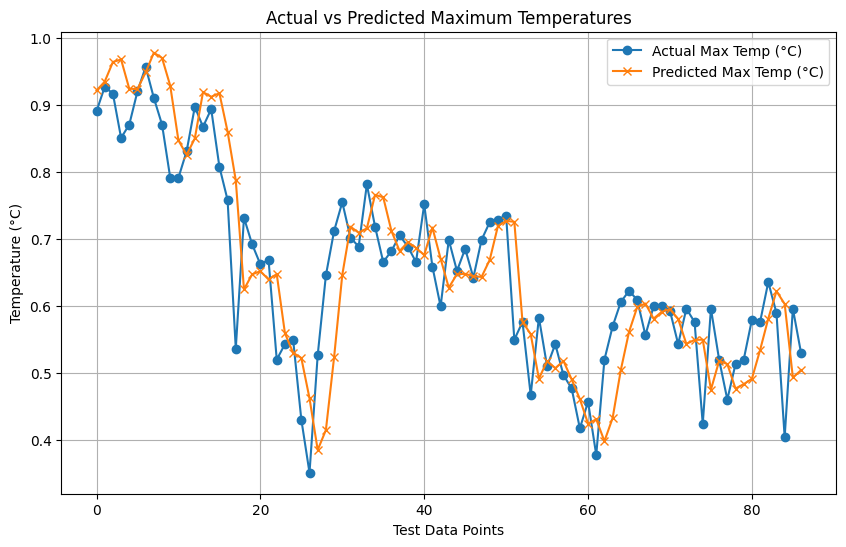

In [4]:
# Plotting Actual vs. Predicted Temperatures
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual Max Temp (°C)', marker='o')
plt.plot(y_pred_final, label='Predicted Max Temp (°C)', marker='x')
plt.title('Actual vs Predicted Maximum Temperatures')
plt.xlabel('Test Data Points')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.show()

In [5]:
# Save the trained model
model.save('best_heatwave_model_new.h5')
print("\nModel saved as 'best_heatwave_model_new.h5'")


Model saved as 'best_heatwave_model_new.h5'


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

Predicted Temperatures for Next 10 Days:
        Date  Predicted Max Temp (°C)
0 2024-09-06                33.865429
1 2024-09-07                33.626818
2 2024-09-08                33.408384
3 2024-09-09                33.229833
4 2024-09-10                33.083407
5 2024-09-11                32.961122
6 2024-09-12                32.857334

No heatwave predicted in the next 10 days.


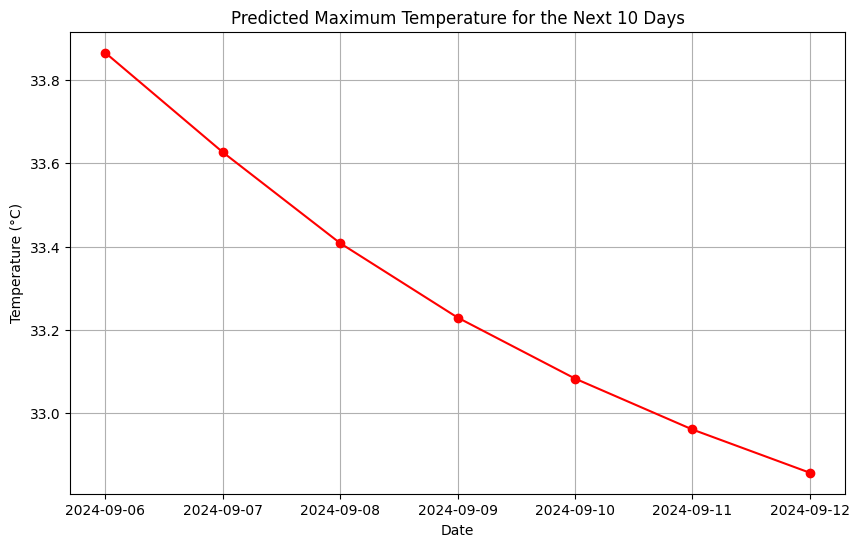

In [6]:
# Predicting the next 10 days using the final model
predictions = []
input_seq = scaled_data[-SEQ_LENGTH:]

for _ in range(7):  # Change from 7 to 10 for predicting 10 days
    input_seq_reshaped = np.reshape(input_seq, (1, SEQ_LENGTH, len(selected_features)))
    predicted_temp = model.predict(input_seq_reshaped)
    predictions.append(predicted_temp[0, 0])
    
    # Update the input sequence with the predicted temperature
    new_data_point = np.append(predicted_temp, input_seq[-1, 1:])  # Adding other features unchanged
    input_seq = np.append(input_seq[1:], [new_data_point], axis=0)

# Inverse transform the predictions to the original scale
predicted_temps = scaler.inverse_transform([np.append([p], input_seq[-1, 1:]) for p in predictions])

# Extract the temperature predictions
predicted_temps = [temp[0] for temp in predicted_temps]

# Get the next 10 days' dates
last_date = pd.to_datetime(weather_data['date'].iloc[-1])
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=7, freq='D')  # Change from 7 to 10 days

# Print predicted temperatures with dates
predicted_results = pd.DataFrame({'Date': future_dates, 'Predicted Max Temp (°C)': predicted_temps})
print("\nPredicted Temperatures for Next 10 Days:")
print(predicted_results)

# Check for heatwave alert
heatwave_threshold = 40  # Define heatwave threshold
consecutive_days_required = 3  # Define number of consecutive days required

heatwave_alert = False
consecutive_days = 0
heatwave_dates = []

for i, temp in enumerate(predicted_temps):
    if temp > heatwave_threshold:
        consecutive_days += 1
        heatwave_dates.append(future_dates[i])
    else:
        consecutive_days = 0
        heatwave_dates = []

    if consecutive_days >= consecutive_days_required:
        heatwave_alert = True
        break

if heatwave_alert:
    print(f"\nHeatwave Alert! High temperatures predicted for {consecutive_days_required} or more consecutive days:")
    print(f"Dates of heatwave: {heatwave_dates}")
else:
    print("\nNo heatwave predicted in the next 10 days.")

# Visualization of Predicted Temperatures for Next 10 Days
plt.figure(figsize=(10, 6))
plt.plot(predicted_results['Date'], predicted_results['Predicted Max Temp (°C)'], marker='o', linestyle='-', color='r')
plt.title('Predicted Maximum Temperature for the Next 10 Days')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.grid(True)
plt.show()